# Bayesian A/B Test Calculator 

This notebook presents step by step instruction how to build a Bayesian A/B Test Calculator with visualization of results using R.

Here is an outline of the project:
### 1. Dataset simulation and  Data manipulation
* To assess the performance of the Bayesina A/B test, I simulate datasets for which true test diferences are known.
* Write functions to process data and compute the cumulative counts and conversions.

### 2. Bayesian A/B test Calculator: 
Write functions to do A/B testing for data observed up to a particular day: 
   - Summarize cumulative counts and cumulative conversion rates by group
   - Derive posterior probability, point estimates and credible interval of difference in proportion
   - Perform Bayesian testing using Bayes factors
   - Visualization of prior, and posterior probabilities

### 3. Repeat Bayesian A/B test on cumulative conversion rate over time: 
For all days, perform Bayesian A/B testing using the above functions:
   - When the user select a particular day after the tests begin, give summaries of Bayesian A/B testing
   - Plot the point estimates of difference in proportion, and thier credible interval over time
   - Plot the probability of each test being the best over time
   - Plot the Bayes factor over time 

### 4. Wrap all functions to build a Shiny web app 
Users can use this app to read A/B test data, perform tests, plot the pior and posterior probabilities, monitor the test progress by examing the trend of cumulative conversion rate change over time, and make decisions.

## 1. Dataset simulation and  Data manipulation

### 1.1  Dataset simulation
To assess the performance of the Bayesina A/B test, I simulate datasets with known true parameters to represent the following scenarios:
1. The test group proportion (p1= 0.04)  is different from that of the control group (p0= 0.02);
2. The test group proportion (p2= 0.025) is slightly different from that of control group (p0= 0.02);
3. The test group proportion (p3= 0.02)  is equal to the control group proportion (A/A test).


To mimic the real A/B test data format, the data I simulated 3 columns: date, group, covert or not. 

In [2]:
# load libraries
library(shiny)
library(dplyr)
library(ggplot2)


### Prior specification
Prior specification is the first step of any Bayesian inference. 
To simplify the problem I choose Beta conjugate prior for proportions.
Assume the proportion $\theta_k \in [0,1]$ for $k =0,...,3 $ are equal for all test groups and $\theta_k$ follow a common gamma distribution: 
$$\theta_k \sim B( \alpha_0 , \beta_0) $$ 
where $\alpha_0>0$ , $\beta_0 >0$. 

To start with, I choose $\alpha_0=1$ , $\beta_0=1$, which correspond to a **uniform prior**. 
In future, more appropriate prior hyperparameters can be specified based on information of historical A/B tests. 

In [3]:
## Bayesian prior parameters
alpha_0 = 1
beta_0  = 1

## Set parameters for simulating data

start_date    = as.Date('2017-01-01')  # start date of tests
test_duration = 60    # length of tests in days
num_tests     = 3     # how many test variants excluding default
counts        = 10000 # total view in each group
prob_list     = c(0.02, 0.04, 0.025, 0.02) # true proportion of Test0, Test1, Test2, Test3
alpha         = 0.05  # Confidence level

In [4]:
## Simulate 4 datasets DF0, DF1, DF2, DF3 with true proportion  c(0.02, 0.04, 0.025, 0.02)

set.seed(198911)  #set a random seed so results can be repeat
for (i in 0:num_tests) {
  assign(paste0("DF", i), data.frame(
      Test_group = i, 
      Date = sample(seq(start_date, start_date+ test_duration -1 , by="day"), counts, replace = TRUE ), 
      Convert = rbinom(n = counts, size= 1, prob = prob_list[i+1]))  
        )
}
# Merge into one dataset
DF = DF0
for ( k in 1:num_tests) {
    DF= rbind(DF, get(paste0("DF", k)) )}
dim(DF)
head(DF)

[1] 40000     3

Test_group,Date,Convert
0,2017-01-19,0
0,2017-03-01,0
0,2017-01-18,0
0,2017-02-13,0
0,2017-01-23,0
0,2017-02-23,0


### 1.2. Data Manipulation and Summary Plots by Group
The Shiny app should be able to convert datasets uploaded like above, to a table with cumulative total and conversion counts to use in Bayesian inference.

Write functions to process data and compute 
1. Cumulative counts and cumulative conversion rate
2. Calculate both frequentist confidence interval (CI) and Bayesian credible region (CR)

In [5]:
# A function to do data manipulation

transform_data <- function(df ,   # data frame 
                           a = alpha ,  # confidence level
                           a_0 = alpha_0, b_0= beta_0 # Beta prior parameter
                          ) {
    result= data.frame()
    for (k in 0:num_tests){
        df_k = df[ df$Test_group == k, ]
        data = table(df_k$Date, df_k$Convert)
        data[,1] = data[,1] + data[,2]

        # calculate the cumulated clicked and cumulated converted
        CumTot  = cumsum(data[,1])
        CumConv = cumsum(data[,2])
        p  =  CumConv/ CumTot 

        ## Upper and lower limit of frequentist confidence interval
        Conf_LL =  p - qnorm(1-a/2, mean = 0, sd = 1) * sqrt( p*(1-p)/CumTot  )
        Conf_UL =  p + qnorm(1-a/2, mean = 0, sd = 1) * sqrt( p*(1-p)/CumTot  )

        ## Summaries based on posterior probability 
        post_alpha = a_0 + CumConv 
        post_beta  = b_0 + CumTot - CumConv 
        post_mean = (post_alpha)/ ( post_alpha + post_beta ) 
        # compute equal-tailed credible interval for the posterior Beta distribution
        Cred_LL = qbeta( a/2 , shape1 = post_alpha , shape2 = post_beta ) 
        Cred_UL = qbeta(1-a/2, shape1 = post_alpha , shape2 = post_beta )    

        data = cbind(Date = as.Date(rownames(data)), as.Date(rownames(data)) - start_date +1, df_k[1,'Test_group'], 
                     data, CumTot  , CumConv, p , Conf_LL, Conf_UL , post_mean, Cred_LL, Cred_UL )

        # save the data set to result
        if (dim(result)[1] > 0){ result= rbind(result, data)}
        else{result= data}
    }
    colnames(result)<- c("Date","Day", "Test_group", "Total","Convert", "Cum_Total", "Cum_Convert", "CRate", 
                           "Conf_LL","Conf_UL" , "Post_mean", "Cred_LL", "Cred_UL")
    return(result)
}

CR = transform_data(DF)
dim(CR)
head(CR)

[1] 240  13

,Date,Day,Test_group,Total,Convert,Cum_Total,Cum_Convert,CRate,Conf_LL,Conf_UL,Post_mean,Cred_LL,Cred_UL
2017-01-01,17167,1,0,169,3,169,3,0.01775148,-0.002156753,0.03765971,0.02339181,0.006447343,0.05070384
2017-01-02,17168,2,0,139,3,308,6,0.01948052,0.004045716,0.03491532,0.02258065,0.009155363,0.04178243
2017-01-03,17169,3,0,170,5,478,11,0.02301255,0.009570641,0.03645446,0.02500000,0.013010334,0.04071773
2017-01-04,17170,4,0,197,5,675,16,0.02370370,0.012227582,0.03517983,0.02511078,0.014716299,0.03815240
2017-01-05,17171,5,0,156,5,831,21,0.02527076,0.014599916,0.03594160,0.02641056,0.016643795,0.03832483
2017-01-06,17172,6,0,175,2,1006,23,0.02286282,0.013626656,0.03209899,0.02380952,0.015328668,0.03407520


### 1.3. Visualization of trend of cumulative conversion rate by group

Below I explore the point estimate and confidence/credible interval using frequentist and Bayesian approach, respectively. 


A function to make colors transparent: 

In [6]:
makeTransparent = function(..., alpha=0.15) {
  # A function to make colors transparent: 
  if(alpha<0 | alpha>1) stop("alpha must be between 0 and 1")
  alpha = floor(255*alpha)  
  newColor = col2rgb(col=unlist(list(...)), alpha=FALSE)
  .makeTransparent = function(col, alpha) {
    rgb(red=col[1], green=col[2], blue=col[3], alpha=alpha, maxColorValue=255)
  }
  newColor = apply(newColor, 2, .makeTransparent, alpha=alpha)
  return(newColor)
}

A function to plot point estimate and confidence region using Bayesian or frequentist methods:

In [7]:
Freq_plot <- function(df, num_tests=2, 
                      Bayes = TRUE)  
{
     # if Bayes== TRUE, plot Bayesian estimate and Credible Interval 
    if (Bayes== TRUE){column = 'Post_mean'; LL = 'Cred_LL' ; UL = 'Cred_UL'; 
                      title= "Bayesian: Posterior Mean and Credible Interval of Proportion Over Time" }
    if (Bayes== FALSE) {column = 'CRate';   LL = 'Conf_LL' ; UL = 'Conf_UL'; 
                      title= "Frequentist: Mean and Confidence Interval of Proportion Over Time" }
    #-------------------------------------------------------------------------
    cbPalette <- c("#009E73","#0072B2", "#E69F00",   "#D55E00", "#CC79A7","#F0E442","#56B4E9",  "#999999")
    fill_colors = makeTransparent(cbPalette)

    # plot the default group
    data = CR[CR[,'Test_group']==0,]   
    
    plot(  data[,'Day'],  data[, column] ,type = "l", lwd = 3, col="red", lty=1 , ylim = c(0,0.07) ,
        main = title, 
        xlab = 'Days after tests start' , ylab= 'Proportion')
    polygon( c(data[,'Day'] , rev(data[,'Day']) ), c(data[, LL] , rev(data[, UL]) ), 
            col=rgb(1, 0, 0,0.1), border=NA)
    
    abline(h=0)
    # plot the rest test groups
    for (k in 1:num_tests){
        data = CR[CR[,'Test_group']==k,]
        lines(  data[,'Day'],  data[, column] ,type = "l", lwd = 3, col= cbPalette[k], lty=k+1   )
        polygon( c(data[,'Day'] , rev(data[,'Day']) ), c(data[,LL] , rev(data[, UL]) ), 
                col= fill_colors[k], border=NA)
        }
    legend(50,  0.06, legend=c("Default", "Test 1", "Test 2", "Test 3"),
       col=c("red", cbPalette[1:k]), lty=1:(k+1), cex=0.8, title="Test group")
    }

### 1.3.1. Frequentist approach: Mean and Confidence Interval

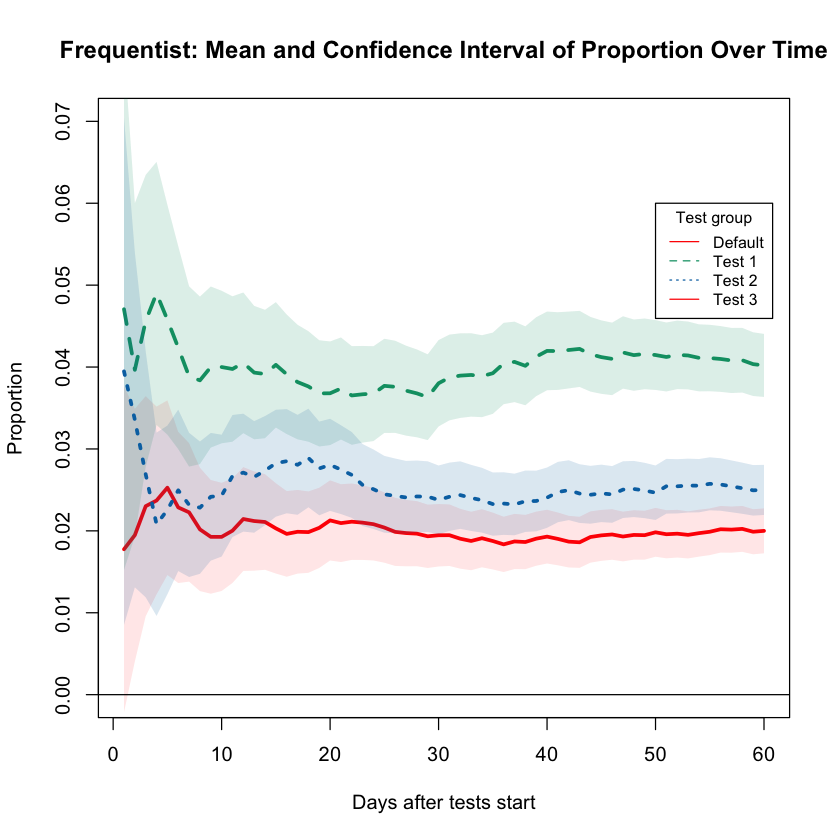

In [8]:
Freq_plot(CR,2, Bayes = FALSE)

### 1.3.2. Bayesian approach: Posterior Mean and Credible Interval 

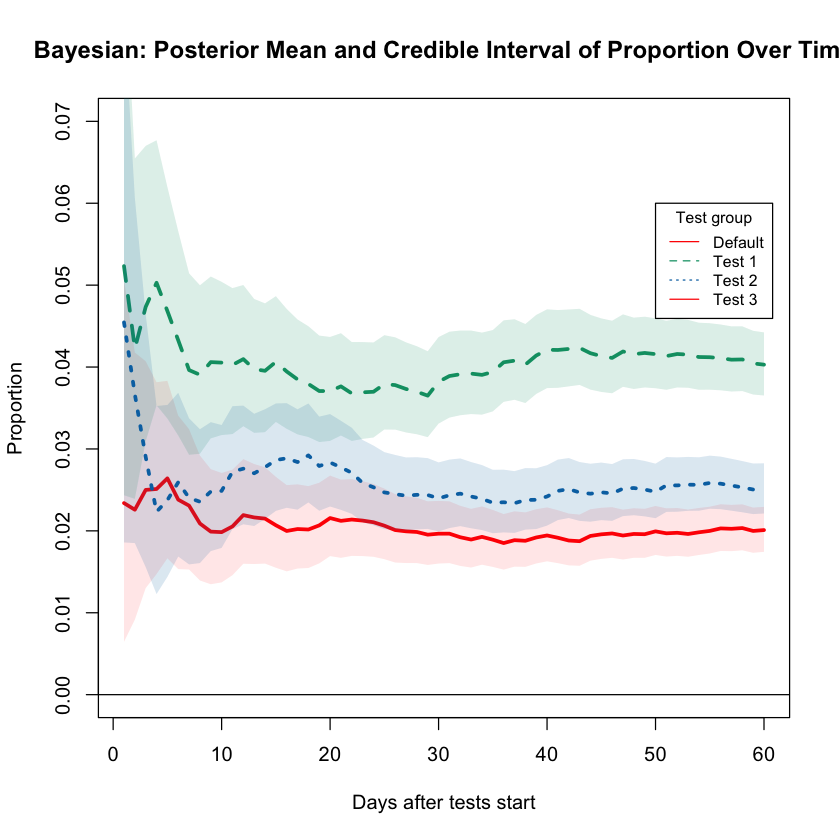

In [9]:
Freq_plot(CR,2, Bayes = TRUE)

## 2. Bayesian A/B test calculator: 
Our goal is to do formal testing on difference between test $k$ and default group, $\theta_k - \theta_0$. So I switch to building a Bayesian A/B test calculator.

#### Input needed:
1. Prior probability hyperparameters: $\alpha_0$ and $\beta0$ in $B(\alpha_0, \beta_0)$
2. Total counts ($n_0$ and $n_k$), conversion counts ($x_0$ and $x_k$) for the default and test group, respectively.

I write functions to do A/B testing for data observed up to a particular day: 
   - Summarize cumulative counts and cumulative conversion rates by group
   - Derive posterior probability, point estimates and credible interval of difference in proportion
   - Perform Bayesian testing using Bayes factors
   - Visualization of prior, and posterior probabilities
   
#### Theoretical derivation(optioinal):    
Assuming equal conjugate Beta prior probabilities
$$\theta_0, \theta_k  \sim^{ind} B(\alpha_0, \beta_0),$$
we have
$$x_0|\theta_0 \sim Bin(n_0, \theta_0),$$
$$ x_k|\theta_k \sim Bin(n_k, \theta_k),$$ 
where $x_0 \perp x_1$. 
Then the posterior distributions are
$$ \theta_0~|x_0, n_0 \sim Beta(\alpha_0+ x_0, \beta_0 + n_0 - x_0),$$
$$ \theta_k~|x_k, n_k \sim Beta(\alpha_0+ x_k, \beta_0 + n_k - x_k).$$

From the above posterior distribution of $\theta_0$ and $\theta_k$, we can simulate the posterior distribution of $\theta_k - \theta_0$

### 2.1 Computation

In [10]:
# A function modified from fomulas on http://www.evanmiller.org/bayesian-ab-testing.html 
prob_B_beats_A = function(alpha_A, beta_A, alpha_B, beta_B){
    total = 0.0
    for (i in 0:(alpha_B-1) ){
        total = total+  exp(lbeta(alpha_A+i, beta_B+ beta_A) - log(beta_B+i) - lbeta(1+i, beta_B) - lbeta(alpha_A, beta_A))
    }
    return (total)    
}

# A/B/C testing: binary outcomes
probability_C_beats_A_and_B <- function(alpha_A, beta_A, alpha_B, beta_B, alpha_C, beta_C){
    total = 0.0
    for (i in 0:(alpha_A-1) ){
        for (j in 0:(alpha_B-1)){
            total = total + exp(lbeta(alpha_C+i+j, alpha_A+alpha_B+alpha_C) - log(alpha_A+i) - log(alpha_B+j))
        }        
    }         
    return (1 - probability_B_beats_A(alpha_C, alpha_C, alpha_A, alpha_A)  - probability_B_beats_A(alpha_C, alpha_C, alpha_B, alpha_B) + total )    
}


In [11]:
Bayes_AB_test <- function(nA, xA, nB, xB, make_plot=TRUE, 
                          alpha0= 1, beta_0= 1){  # set both prior parameters to 1 by default
    # create an empty data frame: 
    result= data.frame(Test= character(), Users = integer(), Conversion= integer(), CR=double(),  
                       Uplift= double(), Chance_of_being_best=double() )

    CR_A = xA/nA*100
    CR_B = xB/nB*100   
    uplift_B = (CR_B- CR_A)/CR_A *100
    
    alpha_A = alpha_0 + xA
    alpha_B = alpha_0 + xB  
    beta_A  = beta_0 + nA-xA
    beta_B  = beta_0 + nB-xB
    
    best_B = 100*prob_B_beats_A (alpha_A, beta_A , alpha_B, beta_B ) 
    best_A = 100- best_B

    result= rbind(c("A", nA, xA, CR_A, NA, best_A) , 
                  c("B", nB, xB, CR_B, uplift_B, best_B))
    colnames(result) = c('Test', 'Users', 'Conversion','CR (%))', 'Uplift (%)', 'Chance of being best (%)')
    if (make_plot ==TRUE){
            # -------------make density plot -----------------#
        theta<-seq(0,1,0.001) #create theta range from 0 to 1
        prior <- dbeta(theta, 1,1)
        posterior_A <- dbeta(theta, alpha_A, beta_A ) 
        posterior_B <- dbeta(theta, alpha_B, beta_B )

        par(mfrow = c(2, 1))
        prob_plot <- plot(theta, prior,  col="gray", lty=2, xlab = 'prop', ylab = "Density",   ylim = c(0,30), 
                         main = "Prior and Posterior Densitys")
        lines(theta, posterior_A, lwd = 3, col="dodgerblue", lty=3)
        lines(theta, posterior_B, lwd = 3, col="orange", lty=3)
        legend("topright",lwd=3,
           c("prior", "posterior_A","posterior_B"),
           col = c( "grey","dodgerblue","orange")
           )
        # ------------- Best probability Bar chart -----------------#
        names <-c("A", "B")
        prob_list = c(best_A, best_B)
        yy <- barplot(prob_list ,main="Chance of B outperforming A", width = 1, horiz=TRUE,names.arg=names,las=1, 
                xlab = "Percent")
        ## Add text at top of bars
        text(y = yy,  x = prob_list, label = prob_list, pos = 3, cex = 0.8)
    }
    
    return (result)
}

### 2.2 Get summary information and plots

Test,Users,Conversion,CR (%)),Uplift (%),Chance of being best (%)
A,110,2,1.81818181818182,NA,38.3302554318394
B,120,3,2.5,37.5,61.6697445681606


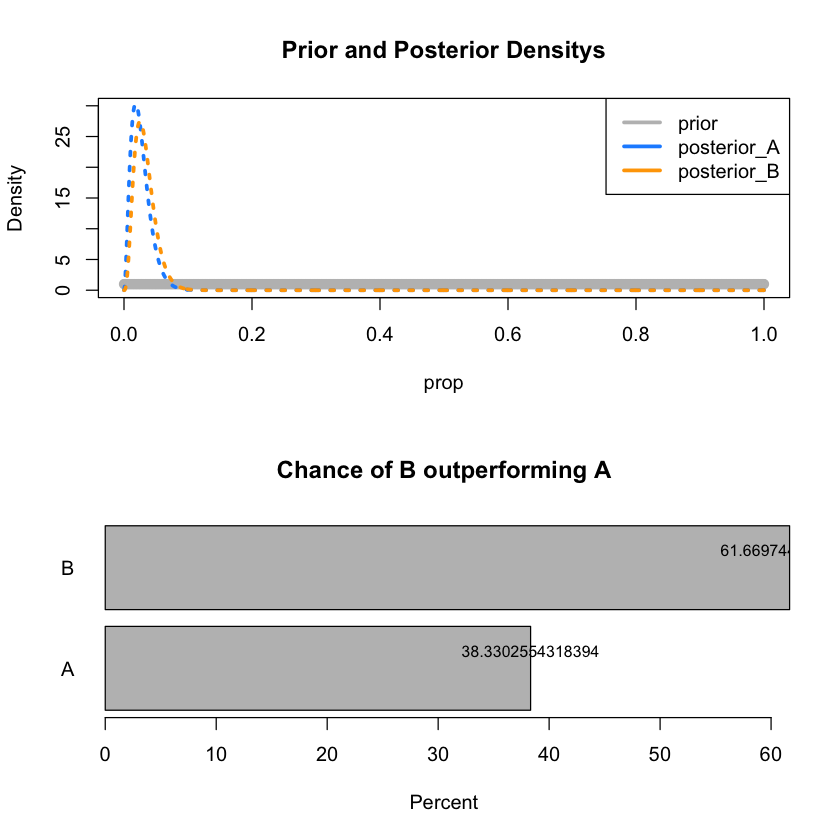

In [12]:
AB_test_result = Bayes_AB_test(nA=110, xA=2, nB=120, xB=3)
AB_test_result

## 3. Bayesian A/B test for cumulative conversion rate: 
For any day, perform Bayesian A/B testing using the above functions:
   - When the user select a particular day after the tests begin, give summaries of Bayesian A/B testing
   - Plot the point estimates of difference in proportion, and thier credible interval over time
   - Plot the probability of each test being the best over time
   - Plot the Bayes factor over time 

In [13]:
Bayes_AB_test(nA=110, xA=2, nB=120, xB=3, make_plot= FALSE)
as.numeric(Bayes_AB_test(nA=110, xA=2, nB=120, xB=3, make_plot= FALSE)[2,6])

Test,Users,Conversion,CR (%)),Uplift (%),Chance of being best (%)
A,110,2,1.81818181818182,NA,38.3302554318394
B,120,3,2.5,37.5,61.6697445681606


[1] 61.66974

In [101]:
Calculate_change <- function(df, k , a = alpha, nsim = 10000){

    CR0 =  CR[CR[,'Test_group'] ==0, c('Day','Cum_Total','Cum_Convert',"CRate") ]
    CR1 =  CR[CR[,'Test_group'] ==k, c('Cum_Total','Cum_Convert',"CRate") ]
    CR01= merge(CR0, CR1, by=0, all=TRUE)
    
    N= dim(CR0)[1]  # total number of days in the study
    
    n0 = CR01[,3]; x0 = CR01[,4]; p0 =  CR01[,5] 
    n1 = CR01[,6]; x1 = CR01[,7]; p1 =  CR01[,8]  

    ## ----------Upper and lower limit of frequentist confidence interval------------
    z = qnorm(1-a/2, mean = 0, sd = 1) 
    Conf_LL =  (p1- p0) - z* sqrt( p0*(1-p0)/n0 + p1*(1-p1)/n1  )
    Conf_UL =  (p1- p0) + z* sqrt( p0*(1-p0)/n0 + p1*(1-p1)/n1  )
    #--------------------------------------------------------------------------------
    # For each day, simulate posterior distribution of difference p1-p0:
    # And compute Upper and lower limit of Bayesian credible interval----------------

    Post_mean <- c()
    Cred_LL   <- c()
    Cred_UL   <- c()
    for (i in 1:N){
        # posterior dist parameters: 
        alpha_A = alpha_0 + x0[i]
        alpha_B = alpha_0 + x1[i]  
        beta_A  = beta_0 + n0[i]-x0[i]
        beta_B  = beta_0 + n1[i]-x1[i]
        # simulate theta0 and theta1
        theta0 = rbeta(n= nsim, shape1 = alpha_A, shape2 =beta_A)
        theta1 = rbeta(n= nsim, shape1 = alpha_B, shape2 =beta_B) 
        # compute the difference
        change = theta1 - theta0
        # compute mean, sd, approximate 1-alpha Credible Interval 
        mean_change = mean(change)
        sd_change   = sd(change)
        Post_mean = c(Post_mean, mean_change)
        Cred_LL   <- c(Cred_LL, mean_change - z * sd_change)
        Cred_UL   <- c(Cred_UL, mean_change + z * sd_change)
    }
    
    
    # -------------------Chance of being better than default, Uplift---------------------

    prob_better <- c()
    Uplift <- c()
    for (i in 1:N){
        prob_better <- c(prob_better, as.numeric(Bayes_AB_test(nA= n0[i], xA=x0[i], 
                                                  nB=n1[i], xB=x1[i], make_plot= FALSE)[2,6]) )
        Uplift     <- c(Uplift    , as.numeric(Bayes_AB_test(nA= n0[i], xA=x0[i], 
                                                  nB=n1[i], xB=x1[i], make_plot= FALSE)[2,5]) )    }
    #--------------------------------------------------------------------------------
    CR01 = cbind(CR01, p1-p0 ,Conf_LL, Conf_UL , Post_mean, Cred_LL, Cred_UL, prob_better, Uplift)
    colnames(CR01) = c("Date","Day", "Total_0","Convert_0", "CRate_0", "Total_1","Convert_1", "CRate_1", 
                       'CRate_change',"Conf_LL", "Conf_UL", "Post_mean", "Cred_LL","Cred_UL",
                       "Prob_better", "Uplift_pct")
    return(CR01)
}

In [104]:
CR01= Calculate_change(CR, 1)
CR02= Calculate_change(CR, 2)
CR03= Calculate_change(CR, 3)
head(CR01)

Date,Day,Total_0,Convert_0,CRate_0,Total_1,Convert_1,CRate_1,CRate_change,Conf_LL,Conf_UL,Post_mean,Cred_LL,Cred_UL,Prob_better,Uplift_pct
2017-01-01,1,169,3,0.01775148,170,8,0.04705882,0.02930734,-0.0082383071,0.06685300,0.02912516,-0.0114982979,0.06974861,92.91737,165.09804
2017-01-02,2,308,6,0.01948052,353,14,0.03966006,0.02017954,-0.0053686440,0.04572772,0.01975671,-0.0069774438,0.04649086,92.96499,103.58829
2017-01-03,3,478,11,0.02301255,526,24,0.04562738,0.02261482,0.0002831292,0.04494652,0.02241206,-0.0005410405,0.04536516,97.35463,98.27169
2017-01-04,4,675,16,0.02370370,694,34,0.04899135,0.02528765,0.0055494899,0.04502581,0.02508222,0.0051189797,0.04504547,99.36352,106.68228
2017-01-05,5,831,21,0.02527076,852,39,0.04577465,0.02050389,0.0028741917,0.03813359,0.02036724,0.0024044291,0.03833005,98.81695,81.13682
2017-01-06,6,1006,23,0.02286282,1015,43,0.04236453,0.01950171,0.0040469116,0.03495651,0.01941074,0.0035688008,0.03525268,99.31189,85.29878


## Plot the point estimates of difference in proportion, and thier credible interval over time

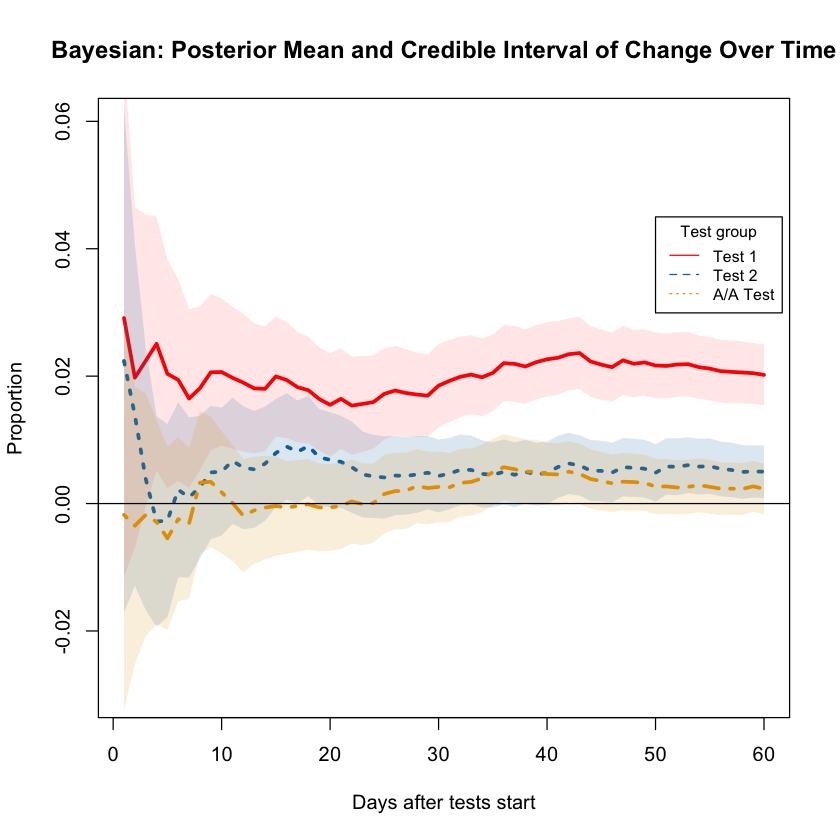

In [105]:
Change_plot <- function( num_tests=3,   Bayes = TRUE)  
{
    # if Bayes== TRUE, plot Bayesian estimate and Credible Interval 
    if (Bayes== TRUE){column = 'Post_mean'; LL = 'Cred_LL' ; UL = 'Cred_UL'; 
                      title= "Bayesian: Posterior Mean and Credible Interval of Change Over Time" }
    else{        column = 'CRate_change';   LL = 'Conf_LL' ; UL = 'Conf_UL'; 
                      title= "Frequentist: Mean and Confidence Interval of Change Over Time" }
    #-------------------------------------------------------------------------
    cbPalette <- c("#009E73","#0072B2", "#E69F00",   "#D55E00", "#CC79A7","#F0E442","#56B4E9",  "#999999")
    fill_colors = makeTransparent(cbPalette)

    # plot the default group
    data =  CR01  
    
    plot(  data[,'Day'],  data[, column] ,type = "l", lwd = 3, col="red", lty=1 , ylim = c(-0.03, 0.06) ,
        main = title, 
        xlab = 'Days after tests start' , ylab= 'Proportion')
    polygon( c(data[,'Day'] , rev(data[,'Day']) ), c(data[, LL] , rev(data[, UL]) ), 
            col=rgb(1, 0, 0,0.1), border=NA)

    # plot the rest test groups
    for (k in 2:num_tests){
        data = get(paste0("CR0", k))
        lines(  data[,'Day'],  data[, column] ,type = "l", lwd = 3, col= cbPalette[k], lty=k+1   )
        polygon( c(data[,'Day'] , rev(data[,'Day']) ), c(data[,LL] , rev(data[, UL]) ), 
                col= fill_colors[k], border=NA)
        }
    abline(h=0)
    
    legend(50,  0.045, legend=c("Test 1", "Test 2", "A/A Test"),
       col=c("red", cbPalette[2:k]), lty=1:(k+1), cex=0.8, title="Test group")

}
Change_plot( Bayes= TRUE)

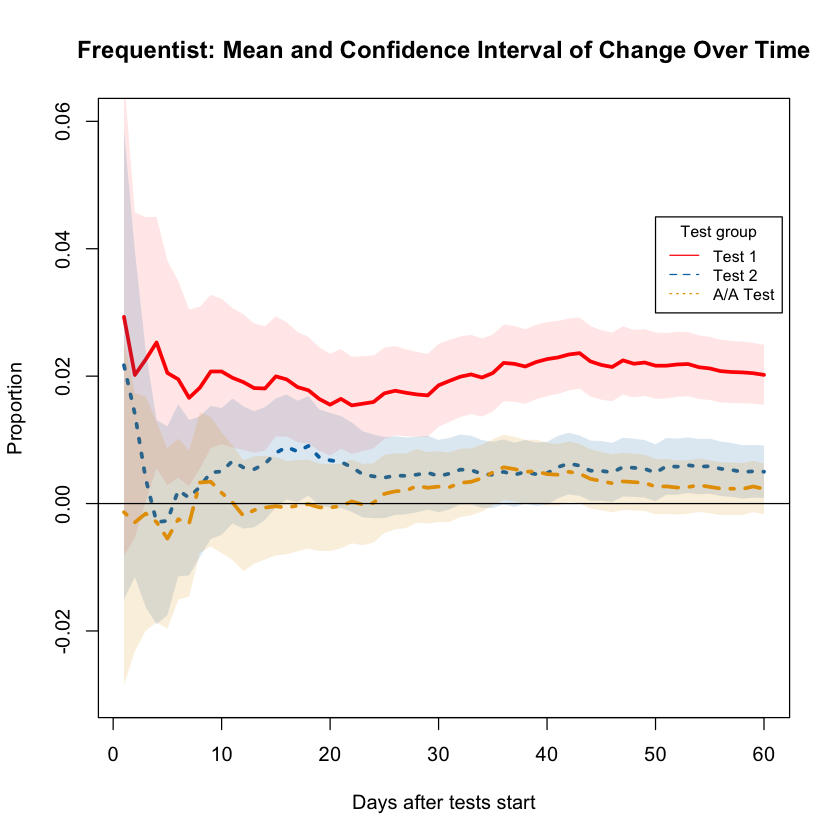

In [106]:
Change_plot( Bayes= FALSE)

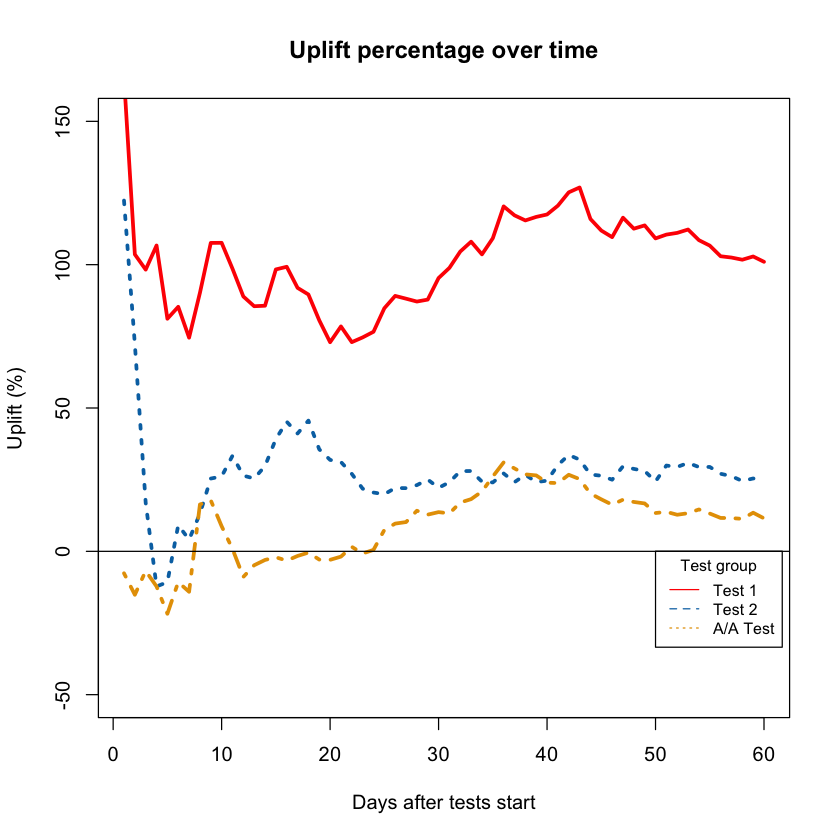

In [108]:
plot_Uplift <- function( num_tests=3, title ="Uplift percentage over time")  
{
    #-------------------------------------------------------------------------
    cbPalette <- c("#009E73","#0072B2", "#E69F00",   "#D55E00", "#CC79A7","#F0E442","#56B4E9",  "#999999")
    fill_colors = makeTransparent(cbPalette)

    # plot the default group
    data =  CR01  
    column ="Uplift_pct"
    plot(  data[,'Day'],  data[, column] ,type = "l", lwd = 3, col="red", lty=1 , ylim = c(-50, 150) ,
        main = title, 
        xlab = 'Days after tests start' , ylab= 'Uplift (%)')
 
    # plot the rest test groups
    for (k in 2:num_tests){
        data = get(paste0("CR0", k))
        lines(  data[,'Day'],  data[, column] ,type = "l", lwd = 3, col= cbPalette[k], lty=k+1   )
        }
    abline(h=0)
    
    legend(50,  0.045, legend=c("Test 1", "Test 2", "A/A Test"),
       col=c("red", cbPalette[2:k]), lty=1:(k+1), cex=0.8, title="Test group")
}
plot_Uplift(3)


## 4. Wrap all functions to build a Shiny web app (To Do)
The Shiny app will be able to:
1. Read A/B test data (date, group, convert or not)
2. Give the summary of A/B test results for all data and plot the pior and posterior probabilities; 
3. An option to show a list of summary for A/B testing results by a certain interval (e.g. every week)
4. Visualize the cumulative conversion rate change and its credible interval over time 